# HMM识别比特币市场结构

解决问题：使用HMM模型识别比特币的市场结构，即划分为“趋势”和“震荡”两个状态，趋势状态意味着价格会持续上涨或下降，震荡状态意味着价格在一个区间内波动。

In [4]:
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler

## 读取数据

In [2]:
file_path = "../data/yahoo/Bitcoin.csv"
df = pd.read_csv(file_path, parse_dates=True, index_col=0)

In [3]:
df.round(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.86,468.17,452.42,457.33,457.33,21056800
2014-09-18,456.86,456.86,413.10,424.44,424.44,34483200
2014-09-19,424.10,427.83,384.53,394.80,394.80,37919700
2014-09-20,394.67,423.30,389.88,408.90,408.90,36863600
2014-09-21,408.08,412.43,393.18,398.82,398.82,26580100
...,...,...,...,...,...,...
2024-12-13,100046.65,101888.80,99233.28,101459.26,101459.26,56894751583
2024-12-14,101451.44,102618.88,100634.05,101372.97,101372.97,40422968793
2024-12-15,101373.53,105047.54,101227.03,104298.70,104298.70,51145914137


## 建模思路

1. 整体框架

- 使用固定长度的时间窗口（如365天）来训练模型
- 窗口逐日向前滚动，每天收盘后使用截止到当天的数据来训练新模型
- 预测当前时间点的市场状态和状态概率
- 滚动窗口模型的优势：
    - 能够适应市场的动态变化
    - 避免使用未来信息
    - 提供实时的状态判断

2. 特征工程

- 基础特征：收益率，波动率
- 成交量：相对成交量比率
- 趋势特征：移动平均线比率
- 每个滚动窗口内独立进行特征标准化
- 确保特征计算不包含未来信息

3. 模型训练

对每个时间窗口，单独进行如下计算：

- 获取该窗口的历史数据
- 计算特征
- 特征标准化
- 训练HMM模型（用户设定状态数）
- 预测当前时间点的状态和状态概率
- 保存结果

举具体例子，假设当前时间点是2024年1月21日，窗口大小是365天，那么：

数据窗口
- 训练窗口：2023年1月21日 - 2024年1月20日（365天）
- 预测窗口：2024年1月21日

模型输出1月21日的市场状态和状态概率，这个信息用于指导1月22号(未来一个交易日)的交易决策。

```
[训练窗口] -> [预测当前] -> [交易决策]
   365天    ->   1/21    ->   1/22
```

4. 实践建议

- 从简单的特征开始，逐步增加有效特征
- 合理选择窗口大小
- 定期评估模型性能
- 结合其它技术指标交叉验证

## 特征工程

初步测试显示，状态切换的频率太高，我猜测可能是特征不够有效，我们可能需要进行特征工程，以下是我认为可能有效的特征：

- 收益率相关
    - 日对数收益率
    - 收益率偏度：Skew(returns, 20), Skew(returns, 50), Skew(returns, 200)
    - 收益率峰度：Kurt(returns, 20), Kurt(returns, 50), Kurt(returns, 200)
- 波动性相关
    - Std(returns, 20)
    - Std(returns, 50)
    - Std(returns, 200)
    - Std(returns, 50) / Std(returns, 200)
- 成交量相关
    - SMA(Volume, 20)
    - SMA(Volume, 50)
    - SMA(Volume, 200)
    - SMA(Volume, 50) / SMA(Volume, 200)
- 趋势指标
    - EMA(20)
    - EMA(50)
    - EMA(200)
    - EMA(50)/EMA(200)
    - ADX(14)
    - AROON(14)

收益率是衡量资产价格变化的基础指标，其分布可能有助于识别市场结构。波动性通常用于衡量风险。成交量反映市场的活跃程度。趋势指标能够辅助识别趋势。回溯窗口之所以选择20，50和200，是因为我想捕捉短期，中期和长期的市场结构。

特征工程建议

1. 使用PCA降维 - 当特征数量过多时使用
2. 选择低相关性特征
3. 考虑因子正交化

特征选择策略

1. 相关性分析
- 计算特征的相关性
- 删除高度相关特征
- 保留经济意义明确的特征

2. 逐步构建
- 从基础特征开始
- 逐步增加有效特征

In [41]:
class RollingHMM:
    def __init__(self, window_size: int = 365, n_states: int = 2) -> None:
        self.window_size = window_size
        self.n_states = n_states

    def prepare_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """准备特征"""
        features = pd.DataFrame(index=df.index)

        # 收益率相关
        features["return"] = np.log(df["close"] / df["close"].shift(1))
        features["skew_20"] = features["return"].rolling(20).skew()
        features["skew_50"] = features["return"].rolling(50).skew()
        features["skew_200"] = features["return"].rolling(200).skew()
        features["kurt_20"] = features["return"].rolling(20).kurt()
        features["kurt_50"] = features["return"].rolling(50).kurt()
        features["kurt_200"] = features["return"].rolling(200).kurt()

        # 波动性相关
        features["volatility_20"] = features["return"].rolling(20).std()
        features["volatility_50"] = features["return"].rolling(50).std()
        features["volatility_200"] = features["return"].rolling(200).std()
        features["volatility_ratio"] = (
            features["volatility_50"] / features["volatility_200"]
        )

        # 成交量相关
        features["volume_20"] = df["volume"].rolling(20).mean()
        features["volume_50"] = df["volume"].rolling(50).mean()
        features["volume_200"] = df["volume"].rolling(200).mean()
        features["volume_ratio"] = features["volume_50"] / features["volume_200"]

        # 趋势指标
        features["ema_20"] = talib.EMA(df["close"], timeperiod=20)
        features["ema_50"] = talib.EMA(df["close"], timeperiod=50)
        features["ema_200"] = talib.EMA(df["close"], timeperiod=200)
        features["ema_ratio"] = features["ema_50"] / features["ema_200"]
        features["adx"] = talib.ADX(df["high"], df["low"], df["close"], timeperiod=14)
        aroon_down, aroon_up = talib.AROON(df["high"], df["low"], timeperiod=14)
        features["aroondown"] = aroon_down
        features["aroonup"] = aroon_up

        return features

    def train_window(
        self, features: pd.DataFrame
    ) -> tuple[hmm.GaussianHMM, StandardScaler]:
        """训练单个窗口的模型"""
        model = hmm.GaussianHMM(
            n_components=self.n_states,
            covariance_type="diag",
            n_iter=2000,
            tol=1e-5,
            random_state=42,
        )

        # 标准化特征
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        # 训练模型
        model.fit(features_scaled)

        return model, scaler

    def rolling_train(self, df: pd.DataFrame) -> pd.DataFrame:
        """实现滚动窗口训练

        Args:
            df(pd.Datafarme): 包含价格数据的数据框，必须包含"close"和"volume"列

        Returns:
            pd.DataFrame: 包含状态和状态概率的数据框
        """
        features = self.prepare_features(df)
        features = features.dropna()

        # 存储所有状态和状态概率
        all_states = pd.Series(index=features.index, name="state")
        all_state_probs = pd.DataFrame(
            columns=[f"state_{i}_proba" for i in range(self.n_states)],
            index=features.index,
        )

        # 滚动训练
        for i in range(self.window_size, len(features)):
            # 获取训练窗口数据
            window_data = features.iloc[i - self.window_size : i]
            current_date = features.index[i]

            # 训练模型
            model, scaler = self.train_window(window_data)

            # 获取当前时间点的数据
            current_features = features.iloc[i : i + 1]
            current_features_scaled = scaler.transform(current_features)

            # 预测状态
            state = model.predict(current_features_scaled)
            all_states.iloc[i] = state

            # 计算状态概率
            state_probs = model.predict_proba(current_features_scaled)
            all_state_probs.loc[current_date] = state_probs[0]

        return pd.concat([features, all_states, all_state_probs], axis=1)

In [38]:
# 准备样本数据
start_date = "2017-01-01"
end_date = "2024-11-30"

prices = df.loc[start_date:end_date].copy()
prices.columns = [x.lower() for x in prices.columns]
prices.drop(columns=["adj close"], inplace=True)
prices.dropna(inplace=True)

prices

,open,high,low,close,volume
Date,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008
...,...,...,...,...,...
2024-11-26,93087.281250,94991.750000,90770.812500,91985.320312,91656519855
2024-11-27,91978.140625,97361.179688,91778.664062,95962.531250,71133452438
2024-11-28,95954.945312,96650.203125,94677.351562,95652.468750,52260008261


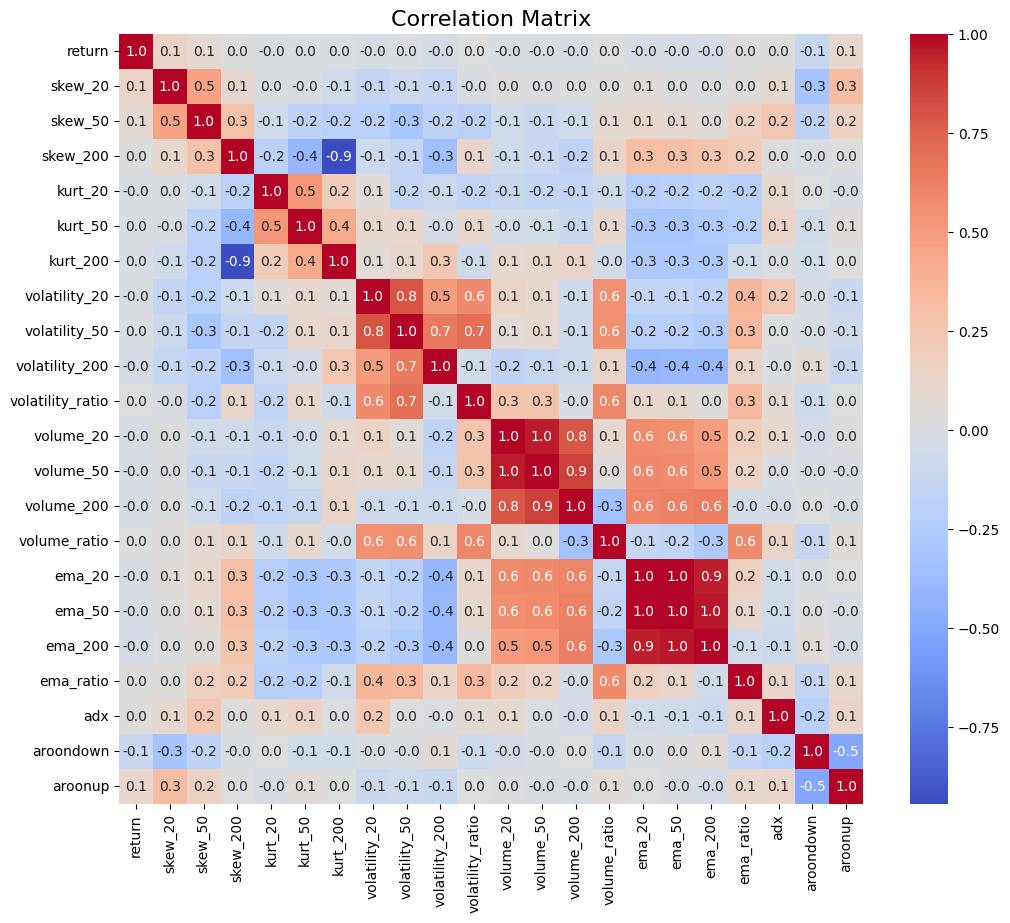

In [39]:
# 准备特征
rolling_hmm = RollingHMM(window_size=365, n_states=2)
features = rolling_hmm.prepare_features(prices)
features = features.dropna()

# 计算相关性矩阵
correlation_matrix = features.corr()
# correlation_matrix

# 使用热力图可视化相关系数矩阵
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".1f",
    annot_kws={"size": 10},
    ax=ax,
)
_ = ax.set_title("Correlation Matrix", fontsize=16)

## 训练模型

In [42]:
# 参数
n_states = 2
window_size = 365

# 训练模型
rolling_hmm = RollingHMM(window_size=window_size, n_states=n_states)
results = rolling_hmm.rolling_train(prices)

Model is not converging.  Current: -8062.242920524965 is not greater than -8062.242918046784. Delta is -2.4781802494544536e-06
Model is not converging.  Current: -8067.960513113098 is not greater than -8067.960512425232. Delta is -6.878663043607958e-07
Model is not converging.  Current: -8145.5826716833135 is not greater than -8145.582669419494. Delta is -2.2638196242041886e-06
Model is not converging.  Current: -8158.728394866346 is not greater than -8158.728390891465. Delta is -3.974881110480055e-06
Model is not converging.  Current: -8172.179042708175 is not greater than -8172.179037319347. Delta is -5.38882795808604e-06
Model is not converging.  Current: -8181.604578091218 is not greater than -8181.6045732300745. Delta is -4.861143679590896e-06
Model is not converging.  Current: -8194.204526518524 is not greater than -8194.204523808023. Delta is -2.7105015760753304e-06
Model is not converging.  Current: -8210.377834906869 is not greater than -8210.377818395562. Delta is -1.65113069

In [44]:
results = results.dropna()
results

,return,skew_20,skew_50,skew_200,kurt_20,kurt_50,kurt_200,volatility_20,volatility_50,volatility_200,...,ema_20,ema_50,ema_200,ema_ratio,adx,aroondown,aroonup,state,state_0_proba,state_1_proba
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-20,-0.015213,0.411451,-0.818462,-0.448522,2.310274,2.495025,1.351664,0.030050,0.033873,0.048829,...,6786.499553,6917.305556,7916.560361,0.873777,30.323949,42.857143,100.000000,1.0,0.0,1.0
2018-07-21,0.008821,0.352165,-0.821996,-0.474657,2.340174,2.492339,1.427728,0.029963,0.033885,0.048362,...,6846.765313,6936.991222,7911.612398,0.876811,30.559206,35.714286,92.857143,1.0,0.0,1.0
2018-07-22,-0.000108,0.528029,-0.802653,-0.470819,2.977758,2.502582,1.430755,0.029281,0.033827,0.048345,...,6901.215306,6955.873536,7906.705710,0.879744,31.032299,28.571429,85.714286,0.0,1.0,0.0
2018-07-23,0.038687,0.304040,-0.794118,-0.471203,2.423605,2.321277,1.417957,0.029821,0.034251,0.048393,...,6978.348121,6985.490647,7904.759483,0.883707,32.004091,21.428571,100.000000,1.0,0.0,1.0
2018-07-24,0.088455,0.529771,-0.552029,-0.504075,1.310033,2.150450,1.407006,0.034800,0.036229,0.048151,...,7116.054922,7041.913348,7909.928737,0.890263,33.947264,14.285714,100.000000,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-26,-0.012070,0.749717,0.990103,0.747680,1.943218,2.111201,2.603468,0.032345,0.027752,0.026451,...,89298.499936,79808.219904,67033.589224,1.190571,51.503805,0.000000,71.428571,0.0,1.0,0.0
2024-11-27,0.042329,0.559572,0.891978,0.728408,1.334065,1.748897,2.478371,0.033104,0.028140,0.026603,...,89933.169585,80441.722310,67321.439393,1.194890,50.304001,0.000000,64.285714,0.0,1.0,0.0
2024-11-28,-0.003236,0.604433,0.915963,0.736469,1.291724,1.903849,2.489428,0.033268,0.027767,0.026599,...,90477.864743,81038.222170,67603.340183,1.198731,49.189897,0.000000,57.142857,0.0,1.0,0.0


## 如何评估模型性能？

1. 使用交易策略回溯检验
- 核心思路：如果当天被识别为“趋势”状态，第二天采取相应的交易行为
- 策略示例：
    - 当天被识别为上升趋势，次日买入
    - 当天被识别为震荡状态，次日持有或平仓
    - 计算策略收益指标以评估模型性能

2. 状态持续性分析
- 计算状态的平均持续时间
- 评估状态转变的频率是否合理
- 分析状态转变是否与市场实际情况相符
- 检验状态转换是否过于频繁（可能表明模型不稳定）

3. 状态特征分析
- 检验不同状态的市场结构是否显著不同

4. 概率预测评估
- 分析状态概率的预测能力
- 当状态概率超过某个阈值时的预测精确度
- 概率预测的稳定性
- 概率变化与市场转折点的关系

5. 交叉验证
- 与其他技术指标进行交叉验证：如ADX, RSI等

6. 稳健性测试
- 改变模型参数如额滚动窗口大小，评估模型的“预测”结果是否会显著变化

性能评估流程建议：

1. 首先进行基础评估
    - 状态特征分析
    - 持续性检验
    - 经济意义分析
2. 然后进行策略回溯检验
    - 设计简单的交易策略
    - 回溯检验
    - 计算策略业绩指标
3. 最后进行稳健性测试
    - 改变模型参数
    - 评估模型性能的稳定性
    - 选择最优参数

## 解读模型结果

1. 可视化状态
2. 状态特征分析，检查不同状态下特征的分布是否有显著不同，如收益率，波动率等
3. 经济意义分析，检查模型输出的状态是否与市场实际情况相符

如何解读状态？

- 模型输出两种不同状态，分别用0和1表示
- 0和1只是标签，本身没有经济意义
- 需要通过分析状态特征来理解其经济意义

如何解读状态概率？

假设某个时点的输出是：[0.7, 0.3]
含义：
- 0.7 是处于状态0的概率
- 0.3 是处于状态1的概率
- 概率之和等于1

如何使用状态概率？

状态概率可以判断处于某种状态的“可信度”，假设处于状态0的概率是90%，那么其可信度就显著高于60%，我们可以设定概率阈值来筛选信号。

如何分析模型结果？

第一步：统计分析
- 计算各状态的平均收益
- 计算各状态的平均波动率
- 分析成交量的特征
- 统计持续时间

第二步：经济意义解读
- 将统计特征与市场状态对应
- 确认是否符合经济直觉

第三步：验证实用性
- 状态转换是否及时
- 状态是否稳定
- 是否具有预测价值

In [55]:
# results2 = results.copy()

In [48]:
# # 计算各状态的统计特征
# results2["state"] = results2["state"].astype(int)
# results2.groupby("state").mean()

可视化结果

In [61]:
results2 = results.loc["2023"].copy()
results2["price"] = prices["close"]

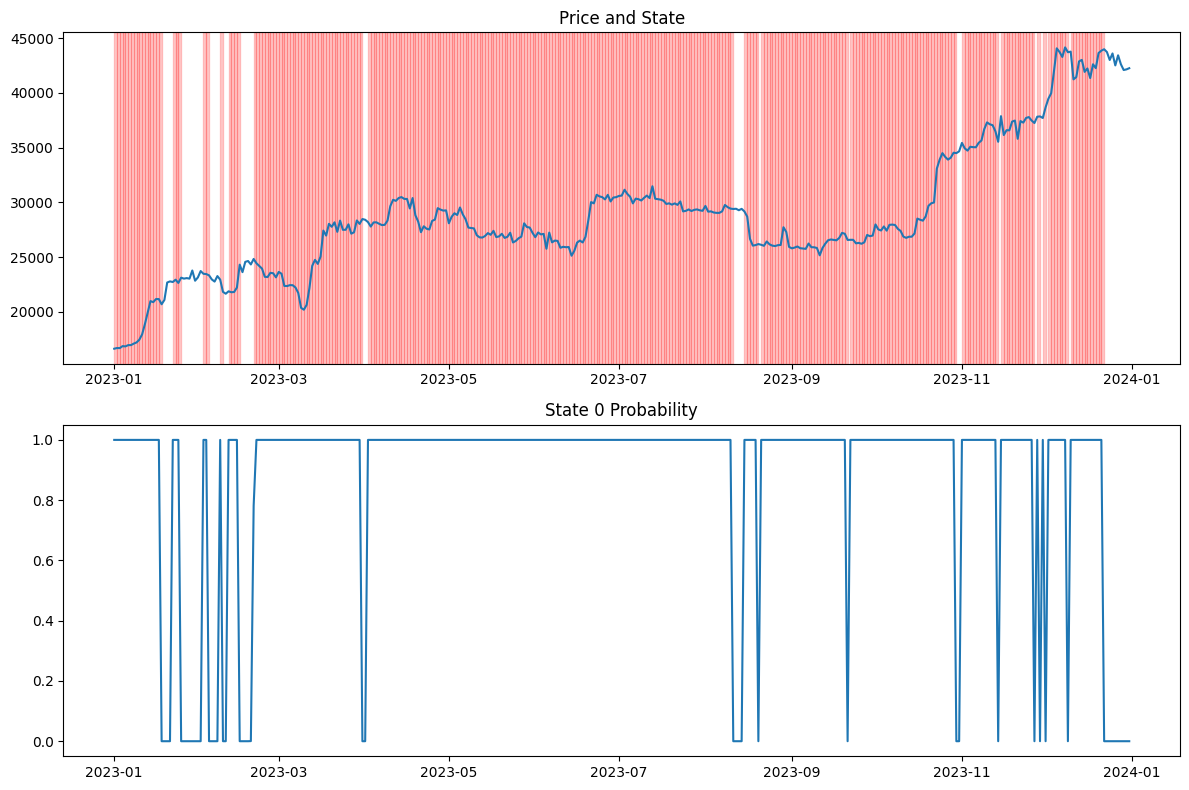

In [62]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# 绘制价格和状态
ax1.plot(results2["price"])
ax1.set_title("Price and State")

# 用背景色表示不同状态
for i in range(len(results2)):
    if results2["state"].iloc[i] == 0:
        ax1.axvspan(
            results2.index[i],
            results2.index[i + 1] if i + 1 < len(results2) else results2.index[-1],
            color="red",
            alpha=0.2,
        )

# 绘制状态概率
ax2.plot(results2["state_0_proba"], label="State 0")
ax2.set_title("State 0 Probability")

plt.tight_layout()